In [21]:
import numpy as np
from numpy import sin, cos, pi
from matplotlib import pyplot as plt
from google.colab import drive
from scipy import optimize
import seaborn as sns
import random
import math

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This script looks for simulation data in your Google drive at the following path: "/content/drive/MyDrive/angle_sweep.dat. This file was generated using RSOFT and can be found in the ATPIC github repo.

**Define search algorythms:**

This section has the definitions for a few different search algorythms.

* Hill Climbing (HC)
* Hill Climbing with Momentum (HCM)
* Ben Ali and Gavin (BAnG)

Because HC and HCM are merely reference points from which to compare the BAnG algorythm, their implementation is functional but not pretty. I wouldn't waste time trying to pick through them for understanding.

All of the algorythms defined below have take a get_power function as an input. This input specifies a data funtion that is used to get an intensity value for a given angle input. These data functions can be found later on.

Finally, you may notice that there are some algorythems with a noise variable like HCM_gaussian and BAnG_noise. These were used to add noise into the the algorythms data function.



In [22]:

def HC(start, res, get_power):
    tmp = 1
    x_center = start
    x_left = start - res
    x_right = start + res
    while(tmp):
        power_center = get_power(x_center)
        power_left = get_power(x_center-res)
        power_right = get_power(x_center+res)
        if((power_left <= power_center) and (power_right <= power_center)): # if at a maxima, end loop.
            tmp = 0;
        elif((power_left >= power_center) and (power_right >= power_center)): # if at a minima, go whichever direction increases faster
            if (power_left > power_right):
                x_center = x_center - res
            else:
                x_center = x_center + res
        elif(power_right > power_center): # continue right if right increases
            x_left = x_center
            x_center = x_right
            x_right = x_right + res
        elif(power_left > power_center): # continue left if left increases
            x_right = x_center
            x_center = x_left
            x_left = x_left - res
    return x_center

def HCM(start, res, momentum, get_power):
    x_center = start
    x_left = start - res
    x_right = start + res
    best_power = 0
    best_x = 0
    peak_found = 0
    dir = 0
    debug = 0
    while(1):
        power_center = get_power(x_center)
        power_left = get_power(x_left)
        power_right = get_power(x_right)

        if (power_center > best_power): # if a better value is found, store it
            best_power = power_center
            best_x = x_center

        if(peak_found == 1): # if a peak has been found,
            for i in range(momentum):   # keep moving in current direction for momentum amount of tries
                x_center = x_center + dir*res
                power_center = get_power(x_center)

                if (power_center > best_power): # if a better value is found, store it and leave momentum
                    if (debug):
                      print('better value found at:' + str(x_center) + ' :' + str(power_center) + ' > ' + str(best_power))
                    best_power = power_center
                    best_x = x_center
                    peak_found = 0
                    break


            if(peak_found == 1): # if a better value is still not found, look other direcion
              x_center = best_x

              for i in range(momentum):   # keep moving in opposite direction for momentum amount of tries
                  x_center = x_center - dir*res
                  power_center = get_power(x_center)

                  if (power_center > best_power): # if a better value is found, store it and leave momentum
                     if (debug):
                      print('better value found at:' + str(x_center) + ' :' + str(power_center) + ' > ' + str(best_power))
                     best_power = power_center
                     best_x = x_center
                     peak_found = 0
                     dir = -dir
                     break


            if(peak_found == 1):
              return best_x,best_power # if no better value is found in momentum, return value

        x_left = x_center - res
        x_right = x_center + res
        power_left = get_power(x_left)
        power_right = get_power(x_right)

        if(debug):
          print('at: ' + str(x_center)+ ' ' + str(power_center) + ' l:' + str(x_left) + ' ' + str(power_left) + ' r:' + str(x_right) + ' ' + str(power_right))

         # if no peak has been found, keep following slope.
        if((power_left < power_center) and (power_right < power_center)): # if at a maxima, end loop.
            peak_found = 1;
            if(debug):
              print('peak found')
        elif((power_left > power_center) and (power_right > power_center)): # if at a minima, go whichever direction increases faster
              if (power_left > power_right):
                  x_center = x_center - res
              else:                                         # this might need fixing
                  x_center = x_center + res
              if (debug):
                print('at minima')
        elif(power_right > power_center): # continue right if right increases
              dir = 1;
              if (debug):
                print('mv r to: ' + str(round(x_right, 3)) + ' ' + str(round(power_right,3)) + 'start: '+ str(round(start, 3)))
              x_left = x_center
              x_center = x_right
              x_right = x_right + res

        elif(power_left > power_center): # continue left if left increases
              dir = -1;
              if (debug):
                print('mv l to: ' + str(round(x_left, 3)) + ' ' + str(round(power_left,3)) + 'start: '+ str(round(start, 3)))
              x_right = x_center
              x_center = x_left
              x_left = x_left - res

        else:
          print('something broke')


def HCM_gaussian(start, res, momentum, get_power, noise):
    x_center = start
    x_left = start - res
    x_right = start + res
    best_power = 0
    best_x = 0
    peak_found = 0
    dir = 0
    debug = 0
    while(1):
        power_center = get_power(x_center,noise_coeff=noise)
        power_left = get_power(x_left,noise_coeff=noise)
        power_right = get_power(x_right,noise_coeff=noise)

        if (power_center > best_power): # if a better value is found, store it
            best_power = power_center
            best_x = x_center

        if(peak_found == 1): # if a peak has been found,
            for i in range(momentum):   # keep moving in current direction for momentum amount of tries
                x_center = x_center + dir*res
                power_center = get_power(x_center,noise_coeff=noise)

                if (power_center > best_power): # if a better value is found, store it and leave momentum
                    if (debug):
                      print('better value found at:' + str(x_center) + ' :' + str(power_center) + ' > ' + str(best_power))
                    best_power = power_center
                    best_x = x_center
                    peak_found = 0
                    break


            if(peak_found == 1): # if a better value is still not found, look other direcion
              x_center = best_x

              for i in range(momentum):   # keep moving in opposite direction for momentum amount of tries
                  x_center = x_center - dir*res
                  power_center = get_power(x_center,noise_coeff=noise)

                  if (power_center > best_power): # if a better value is found, store it and leave momentum
                     if (debug):
                      print('better value found at:' + str(x_center) + ' :' + str(power_center) + ' > ' + str(best_power))
                     best_power = power_center
                     best_x = x_center
                     peak_found = 0
                     dir = -dir
                     break


            if(peak_found == 1):
              return best_x, best_power # if no better value is found in momentum, return value

        x_left = x_center - res
        x_right = x_center + res
        power_left = get_power(x_left,noise_coeff=noise)
        power_right = get_power(x_right,noise_coeff=noise)

        if(debug):
          print('at: ' + str(x_center)+ ' ' + str(power_center) + ' l:' + str(x_left) + ' ' + str(power_left) + ' r:' + str(x_right) + ' ' + str(power_right))

         # if no peak has been found, keep following slope.
        if((power_left < power_center) and (power_right < power_center)): # if at a maxima, end loop.
            peak_found = 1;
            if(debug):
              print('peak found')
        elif((power_left > power_center) and (power_right > power_center)): # if at a minima, go whichever direction increases faster
              if (power_left > power_right):
                  x_center = x_center - res
              else:                                         # this might need fixing
                  x_center = x_center + res
              if (debug):
                print('at minima')
        elif(power_right > power_center): # continue right if right increases
              dir = 1;
              if (debug):
                print('mv r to: ' + str(round(x_right, 3)) + ' ' + str(round(power_right,3)) + 'start: '+ str(round(start, 3)))
              x_left = x_center
              x_center = x_right
              x_right = x_right + res

        elif(power_left > power_center): # continue left if left increases
              dir = -1;
              if (debug):
                print('mv l to: ' + str(round(x_left, 3)) + ' ' + str(round(power_left,3)) + 'start: '+ str(round(start, 3)))
              x_right = x_center
              x_center = x_left
              x_left = x_left - res

        else:
          print('something broke')




def BAnG(left_bound, right_bound, end_resolution, get_power):
    center = (left_bound + right_bound)/2
    tmp = 1;
    left = left_bound
    right = right_bound
    iteration_counter = 0
    best_power = 0
    best_x = 0
    history = []
    while(tmp):
      iteration_counter += 1
      power_center = get_power(center)
      power_left = get_power(left)
      power_right = get_power(right)
      history.append([center, power_center])
      if(power_center > best_power): # keep track of best result
          best_power = power_center
          best_x = center
      if(center - left < end_resolution): # stop after reaching end resolution
          tmp = 0
          #print('min res reached')
          #print('Iterations: ' + str(iteration_counter))
          return best_x, get_power(best_x), history
      if(power_left >= power_right): #if left looks better than right, check left
          old_center = center
          center = (center+left)/2
          right = old_center
      elif(power_left <= power_right): #if right looks better than left, check right
          old_center = center
          center = (center+right)/2
          left = old_center

# This is a search algorythm that is purpose built to take power functions with noise variables
# It will not work with any power functions other than the test_data functions
def BAnG_noise(left_bound, right_bound, end_resolution, get_power, noise):
    center = (left_bound + right_bound)/2
    tmp = 1;
    left = left_bound
    right = right_bound
    iteration_counter = 0
    best_power = 0
    best_x = 0
    history = []
    while(tmp):
      iteration_counter += 1
      power_center = get_power(center, noise)
      power_left = get_power(left, noise)
      power_right = get_power(right, noise)
      history.append([center, power_center])
      if(power_center > best_power): # keep track of best result
          best_power = power_center
          best_x = center
      if(center - left < end_resolution): # stop after reaching end resolution
          tmp = 0
          #print('min res reached')
          #print('Iterations: ' + str(iteration_counter))
          return best_x,get_power(best_x, noise), history

      if(power_left >= power_right): #if left looks better than right, check left
          old_center = center
          center = (center+left)/2
          right = old_center
      elif(power_left <= power_right): #if right looks better than left, check right
          old_center = center
          center = (center+right)/2
          left = old_center

**Get data from .dat file:**

In [23]:
# Parse .dat file
with open("/content/drive/MyDrive/angle_sweep.dat", "rb") as file:
    binary_data = file.read()
    data = binary_data.decode("utf-8")

datapoints = []
for line in data.splitlines():
    datapoints.append(line)
    #print(line)
#print(data)
#print(datapoints[0])
values = []
for point in datapoints:
    values.append(point.split(' '))
#print(values)

x = []
y = []
for pt in values:
    v = []
    for val in pt:
        parts = val.split('e')
        #print(parts)
        base = parts[0]
        exponent = parts[1]
        v.append(float(base) * 10**int(exponent))
    x.append(v[0])
    y.append(v[1])

#plt.plot(x, y)
##plt.show()

global x_rsoft
x_rsoft = x
global y_rsoft
y_rsoft = y

print(max(y))
print(y.index(max(y)))
print(x[41])

0.32884868728000005
41
80.404040404


**Create Data Functions:**

Here are the data function declarations discussed earlier.

In [24]:

def data_function(x):
  # This code turns the rsoft datapoints into a continuous (piecewise linear function).
    x_datapoints = np.array(x_rsoft)
    y_datapoints = np.array(y_rsoft)

    # find which point the requested value is to the right of

    index = np.searchsorted(x_datapoints, x, side="right")-1
    #print(index)

    # if you ask for the last point, give the last point
    if index >= len(x_datapoints) - 1:
        return y_datapoints[-1]
    if index < 0 :
        return y_datapoints[0]

    x0, x1 = x_datapoints[index], x_datapoints[index+1]
    y0, y1 = y_datapoints[index], y_datapoints[index+1]

    m = (y1 - y0) / (x1 - x0)
    b = y0 - m*x0

    return m*x + b

def data_function_gaussian(x, noise_coeff):
  # This code turns the rsoft datapoints into a continuous (piecewise linear function).
    x_datapoints = np.array(x_rsoft)
    y_datapoints = np.array(y_rsoft)

    # find which point the requested value is to the right of

    index = np.searchsorted(x_datapoints, x, side="right")-1
    #print(index)

    # if you ask for the last point, give the last point
    if index >= len(x_datapoints) - 1:
        return y_datapoints[-1]
    if index < 0 :
        return y_datapoints[0]

    x0, x1 = x_datapoints[index], x_datapoints[index+1]
    y0, y1 = y_datapoints[index], y_datapoints[index+1]

    m = (y1 - y0) / (x1 - x0)
    b = y0 - m*x0

    return m*x + b + np.random.normal(0, noise_coeff)

def test_data(x,noise_coeff=0, shift=0):
  if type(x) == list:
    for value in x:
      if value > 6:
        value = 6
      if value < 0:
        value = 0

  return 5*sin(0.9*(x - shift)) + noise_coeff*sin(x - shift)*cos(6*(x - shift))*cos(16*(x - shift)) + 5

def test_data_noisy(x,noise_coeff=1, shift=0):

  return 5*sin(0.9*(x - shift)) + noise_coeff*sin(x - shift)*cos(6*(x - shift))*cos(16*(x - shift)) + 5

def test_data_gaussian(x,noise_coeff=1, shift=0):
  return 5*sin(0.9*(x - shift)) + np.random.normal(noise_coeff)

def noise(x):
  return sin(x)*cos(6*x)/2 + .5


In [25]:
# testing continuous function
search_space = np.linspace(10, 170, 1000)
search_data = []
for i in search_space:
  search_data.append(data_function(i))
print(search_data)

[0.12758991113, 0.128551918879455, 0.12951392662890995, 0.1304759343783649, 0.1314379421278199, 0.13239994987727488, 0.13336195762672984, 0.1343239653761848, 0.13528597312563978, 0.13624798087509477, 0.13720998862454972, 0.13816670467208658, 0.13910970549227625, 0.14005270631246597, 0.14099570713265563, 0.14193870795284536, 0.14288170877303502, 0.14382470959322471, 0.1447677104134144, 0.1457107112336041, 0.1466537120537938, 0.1475967128739835, 0.14852665580976404, 0.14944620573559503, 0.150365755661426, 0.15128530558725695, 0.1522048555130879, 0.15312440543891886, 0.15404395536474985, 0.15496350529058078, 0.15588305521641177, 0.15680260514224273, 0.1577221550680737, 0.15862143167755532, 0.1595167087891658, 0.16041198590077624, 0.16130726301238668, 0.16220254012399715, 0.16309781723560762, 0.16399309434721807, 0.16488837145882854, 0.165783648570439, 0.16667892568204945, 0.16757155216731418, 0.16844350376668066, 0.1693154553660471, 0.1701874069654136, 0.17105935856478005, 0.1719313101641

###**Test HC:**

For graps with lines between dots, the endpoints represent the algorythm starting point and end point.

1.7500000000000013
1.7466666666666675
1.7433333333333336
1.7499999999999998
1.7466666666666804
1.7433333333333612
1.7500000000000424
1.7466666666667225
8.723333333333262
8.729999999999942


Text(0.5, 1.0, 'Hill Climbing on Smooth Function:')

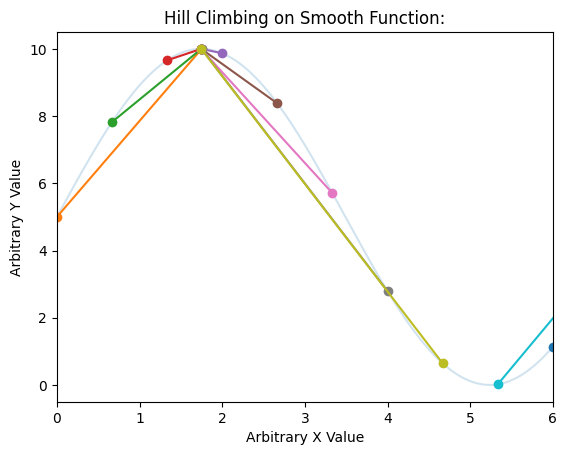

In [26]:
x = np.linspace(0, 6, 1000)
y = test_data(x)
noise = 0

test_points = np.linspace(0, 6, 10)
plt.plot(x, y, alpha=0.2)
for i in test_points:
    gd_result = HC(i, .01, test_data)
    print(gd_result)
    plt.plot([i,gd_result], [test_data(i,noise_coeff=noise),test_data(gd_result,noise_coeff=noise)], marker = 'o')
    #plt.scatter(gd_result, get_power(gd_result))
plt.xlim(0,6)

plt.xlabel("Arbitrary X Value")
plt.ylabel("Arbitrary Y Value")
plt.title("Hill Climbing on Smooth Function:")



Text(0.5, 1.0, 'Hill Climbing on Noisy Function:')

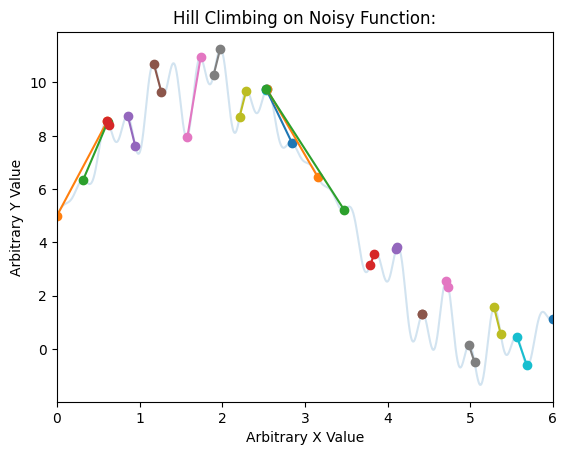

In [27]:
x = np.linspace(0, 6, 1000)
noise = 2
y = test_data_noisy(x, noise_coeff = noise)

test_points = np.linspace(0, 6, 20)

plt.plot(x, y, alpha=0.2)
for i in test_points:
    gd_result = HC(i, .01, test_data_noisy)
    plt.plot([i,gd_result], [test_data_noisy(i,noise_coeff=noise),test_data_noisy(gd_result,noise_coeff=noise)], marker = 'o')
    #plt.scatter(gd_result, get_power(gd_result))
plt.xlim(0,6)

plt.xlabel("Arbitrary X Value")
plt.ylabel("Arbitrary Y Value")
plt.title("Hill Climbing on Noisy Function:")

###**Test HCM:**

Text(0.5, 1.0, 'Hill Climbing with Momentum on Smooth Function:')

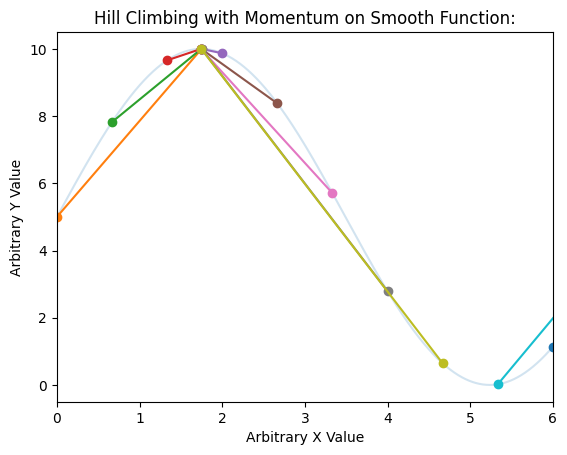

In [28]:
x = np.linspace(0, 6, 1000)
y = test_data(x)
noise = 0

test_points = np.linspace(0, 6, 10)
plt.plot(x, y, alpha=0.2)
for i in test_points:
    hc_result, hc_power= HCM(i, .01, 5, test_data)

    plt.plot([i,hc_result], [test_data(i,noise_coeff=noise),hc_power], marker = 'o')
    #plt.scatter(gd_result, get_power(gd_result))
plt.xlim(0,6)

plt.xlabel("Arbitrary X Value")
plt.ylabel("Arbitrary Y Value")
plt.title("Hill Climbing with Momentum on Smooth Function:")

Text(0.5, 1.0, 'Hill Climbing with Momentum = 50:')

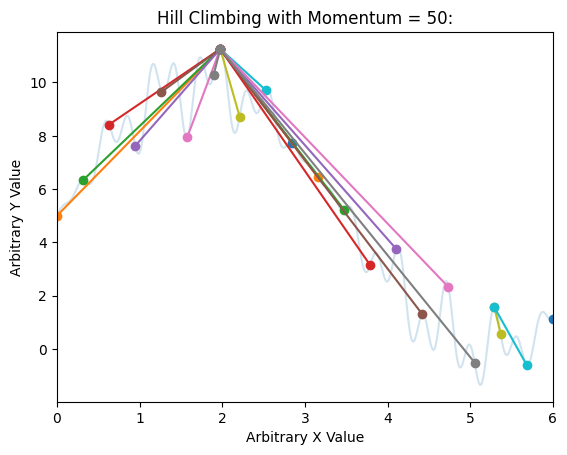

In [29]:
x = np.linspace(0, 6, 1000)
noise = 2
y = test_data_noisy(x, noise_coeff = noise)

test_points = np.linspace(0, 6, 20)
#test_points = [1.28]
plt.plot(x, y, alpha=0.2)
for i in test_points:
    hc_result, hc_power = HCM(i, .001, 500, test_data_noisy)

    plt.plot([i,hc_result], [test_data_noisy(i,noise_coeff=noise),test_data_noisy(hc_result,noise_coeff=noise)], marker = 'o')
    #plt.scatter(gd_result, get_power(gd_result))
plt.xlim(0,6)

plt.xlabel("Arbitrary X Value")
plt.ylabel("Arbitrary Y Value")
plt.title("Hill Climbing with Momentum = 50:")

20
20


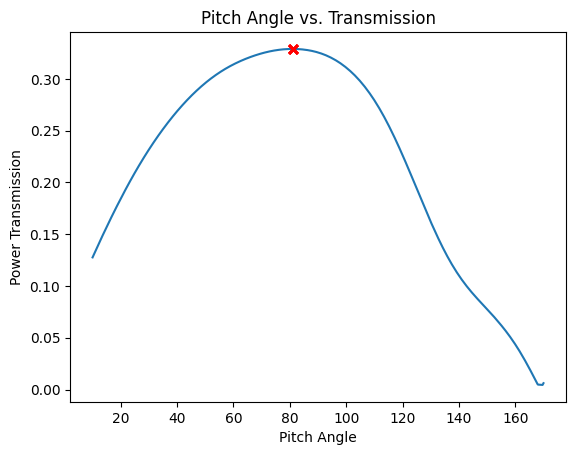

In [30]:

HCM_results = []
HCM_power = []
for _ in range(20):
  start = random.randint(20, 160)
  angle, power = HCM(start, 1, 20, data_function)
  HCM_results.append(angle)
  HCM_power.append(power)
  #plt.plot([start,angle], [data_function(start),power], marker = 'o', alpha = .3,zorder = -1)

print(len(HCM_results))
print(len(HCM_power))

search_space = np.linspace(10, 170, 1000)
search_data = []
for i in search_space:
  search_data.append(data_function(i))


plt.plot(search_space, search_data, zorder = -1) # plot the rsoft data
plt.scatter(HCM_results, HCM_power, alpha = 1, c='red', marker = 'x', zorder = 1) # plot the history of the algorythm
plt.xlabel("Pitch Angle")
plt.ylabel("Power Transmission")
plt.title("Pitch Angle vs. Transmission")
plt.show()

20
20


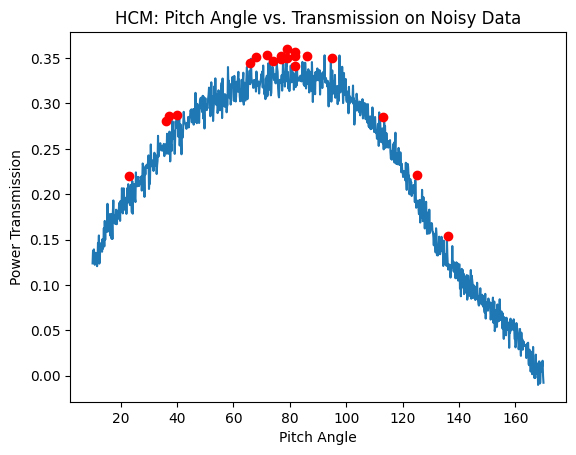

In [31]:
noise = .01


HCM_results = []
HCM_power = []
for _ in range(20):
  start = random.randint(20, 160)
  angle, power = HCM_gaussian(start, 1, 20, data_function_gaussian, noise)
  HCM_results.append(angle)
  HCM_power.append(power)
print(len(HCM_results))
print(len(HCM_power))

search_space = np.linspace(10, 170, 1000)
search_data = []
for i in search_space:
  search_data.append(data_function_gaussian(i, .01))


plt.plot(search_space, search_data, zorder = -1) # plot the rsoft data
plt.scatter(HCM_results, HCM_power, alpha = 1, c='red') # plot the history of the algorythm
plt.xlabel("Pitch Angle")
plt.ylabel("Power Transmission")
plt.title("HCM: Pitch Angle vs. Transmission on Noisy Data")
plt.show()

###**Test BAnG:**

Testing BAnG on arbitrary smooth function.

1.74609375


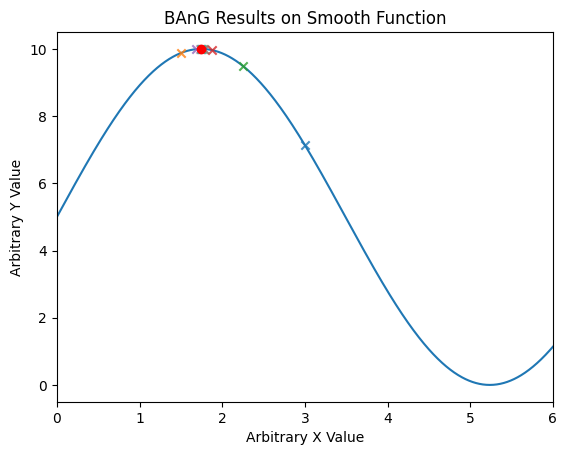

In [32]:
# Calling BAnG on non noisey function

test_search_space = np.linspace(0, 6, 1000)
BAnG_result,BAnG_power, history = BAnG(0, 6, .01, test_data)
print(BAnG_result)

for point in history: # plot the history of the algorythm
    plt.scatter(point[0], point[1], alpha = .8, marker='x')
plt.scatter(BAnG_result, BAnG_power, alpha = 1, c='red') # Plot last point

test_results = [] # get the data function and plot it
for i in test_search_space:
  test_results.append(test_data(i))
plt.plot(test_search_space, test_results, zorder = -1) # plot the rsoft data

plt.xlabel("Arbitrary X Value")
plt.ylabel("Arbitrary Y Value")
plt.title("BAnG Results on Smooth Function")

plt.xlim(0, 6)
plt.show()

Testing BAnG on noisy function

1.734375


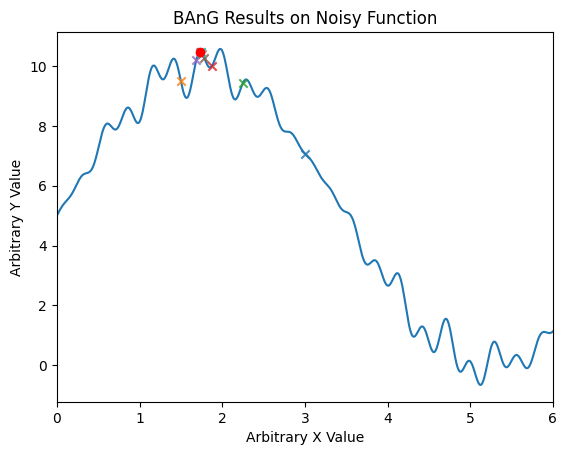

In [33]:
# Calling BAnG on noisey function

test_search_space = np.linspace(0, 6, 1000)
BAnG_result, BAnG_power, history = BAnG(0, 6, .01, test_data_noisy)
print(BAnG_result)

for point in history:
    plt.scatter(point[0], point[1], alpha = .8, marker='x') # plot the history of the algorythm
plt.scatter(BAnG_result, BAnG_power, alpha = 1, c = 'red') # plot the last value

test_results = [] # get the data function and plot it
for i in test_search_space:
  test_results.append(test_data_noisy(i))
plt.plot(test_search_space, test_results, zorder = -1) # plot the rsoft data

plt.xlabel("Arbitrary X Value")
plt.ylabel("Arbitrary Y Value")
plt.title("BAnG Results on Noisy Function")

plt.xlim(0, 6)
plt.show()

Test the BAnG algorythm on RSOFT Data.

X optimal:80.63671875
P optimal:0.3288430151085435


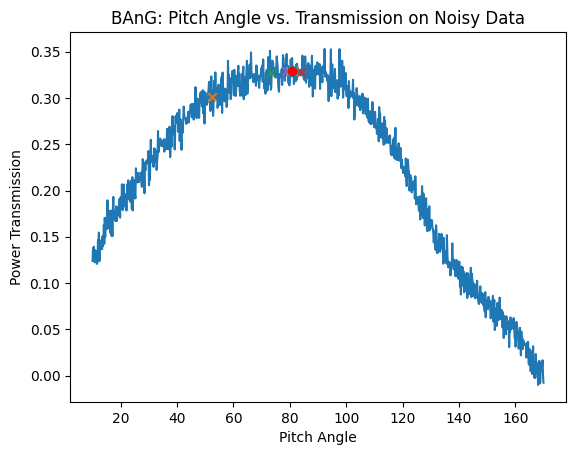

In [34]:
# Calling BAnG
BAnG_result, BAnG_power, history = BAnG(10, 179, .1, data_function)
print("X optimal:" + str(BAnG_result))
print("P optimal:" + str(BAnG_power))
for point in history:
    plt.scatter(point[0], point[1], alpha = .8, marker='x')
plt.plot(search_space, search_data, zorder = -1) # plot the rsoft data
plt.scatter(history[-1][0], history[-1][1], alpha = 1, c='red') # plot the history of the algorythm
plt.xlabel("Pitch Angle")
plt.ylabel("Power Transmission")
plt.title("BAnG: Pitch Angle vs. Transmission on Noisy Data")
plt.show()

BAnG Noise Analysis:

[0.17801562500000045, 0.5082512363281249, 0.7256646523437567, 0.8519132441406295, 1.0460851318359432, 1.1491064150390675, 1.2443515400390643, 1.4245831484375027, 1.5593019082031268, 1.5867533867187509, 1.606935771484375, 1.7382252724609384, 1.798287963867188, 1.8613199726562477, 1.886830404296872, 1.8654245439453123, 1.9317849746093736, 1.9279173515624983, 1.9300117958984349, 2.030162356445309, 2.105580490234372, 2.0643818242187484, 2.1848112509765616, 2.186117381835934, 2.252035221679686, 2.3472216396484358, 2.2609717285156212, 2.293531978515624, 2.364337967773439, 2.3779324599609364, 2.4438054833984366, 2.4854335517578114, 2.42577990332031, 2.4862218652343717, 2.5371119326171856, 2.6471400087890586, 2.559420325195313, 2.676128548828128, 2.7360272119140636, 2.7076196806640644, 2.736918668945312, 2.8249261347656263, 2.7949590048828137, 2.8851579121093756, 2.8480940986328154, 2.9962457578125044, 3.011099644531256, 3.1209986513671906, 2.975767331054696, 3.1087151542968785, 3.048722567382

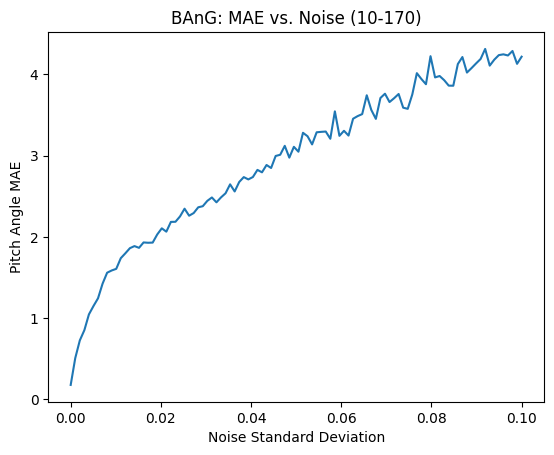

In [35]:

actual_x = 80.637
actual_y = 0.3288430151085435

x_found = []
y_found = []
er = []
for i in range(100):
  noise_coeff = i/10000
  ave_error = 0
  for i in range (1000):
    BAnG_result,BAnG_power, history = BAnG_noise(10, 160, .01,  data_function_gaussian, noise = noise_coeff)
    error = abs(BAnG_result - actual_x)
    ave_error += error
  ave_error = ave_error/1000
  er.append(ave_error)
print(er)



noise_range = np.linspace(0, .1, 100)

#sns.regplot(x=noise_range, y=er, ci=False, line_kws={'color':'red'});
plt.xlabel("Noise Standard Deviation")
plt.ylabel("Pitch Angle MAE")
plt.title("BAnG: MAE vs. Noise (10-170)")
plt.plot(noise_range, er)



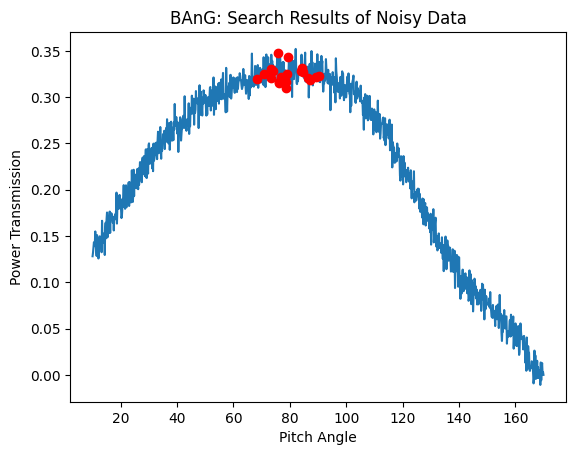

In [36]:
search_space = np.linspace(10, 170, 1000)
search_data = []
for i in search_space:
  search_data.append(data_function_gaussian(i, .01))

for _ in range(20):
  BAnG_result,BAnG_power, history = BAnG_noise(10, 179, .01,  data_function_gaussian, noise = noise_coeff)
  plt.scatter(BAnG_result, BAnG_power, alpha = 1, c = 'red') # plot the history of the algorythm

plt.plot(search_space, search_data,zorder = -1) # plot the rsoft data
plt.xlabel("Pitch Angle")
plt.ylabel("Power Transmission")
plt.title("BAnG: Search Results of Noisy Data")
plt.show()